In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()
using LinearAlgebra
using ForwardDiff
using RobotZoo
using RobotDynamics
using Ipopt
using MathOptInterface
using TrajOptPlots
const MOI = MathOptInterface
using Random
using Plots
include("quadruped.jl")
include("sparseblocks.jl")
include("quadratic_cost.jl")
include("nlp.jl")
include("moi.jl")

  Activating environment at `C:\Users\pnadan\Documents\GitHub\Optimal-Control-Project\Project.toml`


WebIO._IJuliaInit()

solve

## Dynamics Models

In [58]:
include("simple_quadruped.jl")
full_model = UnitreeA1()
n,m = state_dim(full_model), control_dim(full_model)
mvis = initialize_visualizer(full_model);
model = simplifyQuadruped(full_model)
n,m = state_dim(model), control_dim(model);

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8701
└ @ MeshCat C:\Users\pnadan\.julia\packages\MeshCat\GlCMx\src\visualizer.jl:73


## Reference Trajectory & Contact Sequence

In [50]:
include("ref_trajectory.jl")
include("gait.jl")

# Discretization
tf = 4.4
dt = 0.1
N = Int(ceil(tf/dt)) + 1
times = range(0,tf, length=N);

# Reference Trajectory
Xref,Uref = reference_trajectory(model, times)

# Contact Sequence
M = 5 # NOTE: check later, is this physically feasible w/ our dt
contact_sched = contact_sequence_trot(times, M);

## Define NLP for IPOPT

In [51]:
include("moi.jl")
include("nlp.jl")
include("nlp_cost.jl")
include("nlp_constraint.jl")

# Define cost function
Q = Diagonal([1; 10; fill(1.0, 17); 1; 10; fill(1.0, 16)]);
R = Diagonal(fill(1e-3,12))
Qf = Q;
obj = map(1:N-1) do k
    LQRCost(Q,R,Xref[k],Uref[k])
end
push!(obj, LQRCost(Qf, R*0, Xref[N], Uref[1]))

# Unit test: constraint Jacobian matches result from ForwardDiff
let
    nlp = HybridNLP(model, obj, tf, N, M, Xref[1], Xref[end], contact_sched, use_sparse_jacobian=true);
    Random.seed!(1)
    Xguess = [x + 0.1*randn(length(x)) for x in Xref]
    Uguess = [u + 0.1*randn(length(u)) for u in Uref]
    Z0 = packZ(nlp, Xguess, Uguess);
    initialize_sparsity!(nlp)
    rc = getrc(nlp.blocks)
    r = [t[1] for t in rc]
    c = [t[2] for t in rc]
    jacvec = zeros(length(rc))
    jac_c!(nlp, jacvec, Z0)
    jac = sparse(NonzerosVector(jacvec, nlp.blocks));
    
    jac_n = ForwardDiff.jacobian(x->eval_c!(nlp, zeros(eltype(x), num_duals(nlp)), x), Z0)
    for i = 1:5
        println(jac[nlp.cinds[i],:] ≈ jac_n[nlp.cinds[i],:])
    end
end

# Define the NLP
nlp = HybridNLP(model, obj, tf, N, M, Xref[1], Xref[end], contact_sched, use_sparse_jacobian=true);
Random.seed!(1)
Xguess = [x + 0.1*randn(length(x)) for x in Xref]
Uguess = [u + 0.1*randn(length(u)) for u in Uref]
Z0 = packZ(nlp, Xguess, Uguess);

true
true
false
false
false


## Solve NLP

In [ ]:
Z_sol, solver = solve(Z0, nlp, c_tol=1e-6, tol=1e-6, max_iter=100)

## Controller

In [77]:
include("controller.jl")
Xsol,Usol = unpackZ(nlp,Z0)
A = [zeros(n,n) for k = 1:N-1]
B = [zeros(n,m) for k = 1:N-1]
for k = 1:N-1
    A[k], B[k] = discrete_jacobian(nlp.model, Xsol[k], Usol[k], nlp.times[k], nlp.times[k+1]-nlp.times[k], nlp.modes[:,k])
end
K, P = tvlqr(A,B,Q,R,Qf);

## Simulation

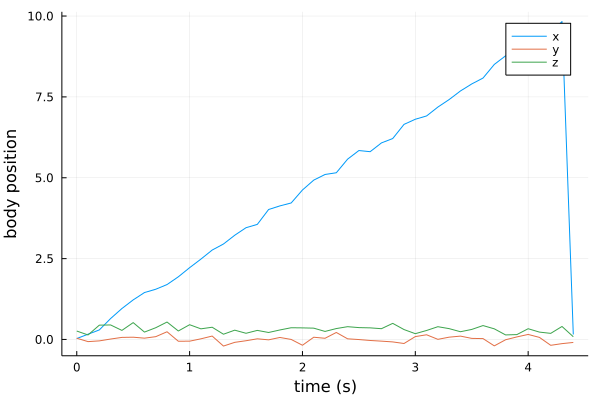

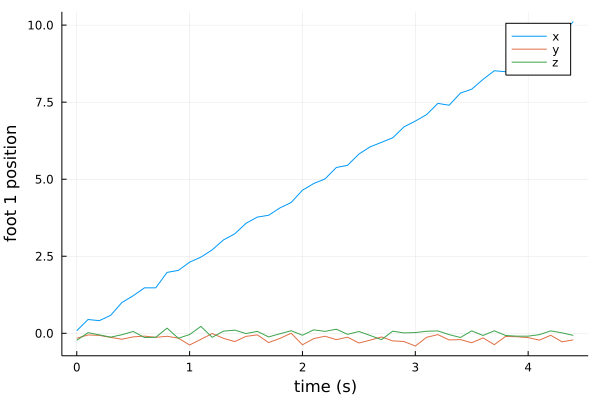

In [40]:
Xsol,Usol = unpackZ(nlp,Z0)
Xmat = zeros(N, n)
for k = 1:N
    Xmat[k,:] = Xsol[k]
end
display(plot(nlp.times, Xmat[:,1:3], label = ["x" "y" "z"], xlabel="time (s)", ylabel="body position"))
display(plot(nlp.times, Xmat[:,8:10], label = ["x" "y" "z"], xlabel="time (s)", ylabel="foot 1 position"))

## Model Limitations
* No impulse on body from foot impact
* Zero length constraint jacobian with respect to attitude quaternion (due to shoulder offset)
* Swing feet can slide on floor (instead of lifting off along some spline)
* No friction cone limits